In [1]:
import tensorflow as tf
import numpy as np
import cv2
import random
import pathlib
from tqdm import tqdm
import os

import einops
#import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import layers


In [2]:
# Verifica se há GPU disponível e força o TensorFlow a usá-la
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Evita estouro de memória da GPU
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=8192)]  # Ajuste para metade da sua VRAM
        )
    except RuntimeError as e:
        print(e)


## Pré-Processamento dos vídeos

In [3]:
def format_frames(frame, output_size=(224, 224)):
    """
    Redimensiona e normaliza os frames.

    Args:
        frame: Frame (imagem) a ser processado.
        output_size: Tamanho de saída (height, width).

    Return:
        Frame formatado e normalizado.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)  # Normaliza entre [0, 1]
    frame = tf.image.resize_with_pad(frame, *output_size)  # Redimensiona com padding
    return frame


def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
    """
    Extrai frames de um vídeo específico.

    Args:
        video_path: Caminho completo do vídeo.
        n_frames: Número de frames a extrair.
        output_size: Tamanho de cada frame (altura, largura).
        frame_step: Número de frames a pular entre capturas.

    Return:
        NumPy array com frames no formato (n_frames, altura, largura, canais).
    """
    result = []
    cap = cv2.VideoCapture(str(video_path))
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    need_length = 1 + (n_frames - 1) * frame_step

    # Se o vídeo for muito curto para pegar todos os frames com frame_step, pega os frames do início
    if need_length > video_length:
        start = 0
        # Calcula o número de frames adicionais necessários
        extra_frames = n_frames - video_length // frame_step
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start)
        extra_frames = 0

    cap.set(cv2.CAP_PROP_POS_FRAMES, start)

    for i in range(n_frames):
        for _ in range(frame_step):
            ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, output_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
            result.append(frame)
        else:
            # Se não houver mais frames, preenche com os frames do início até completar o número necessário
            if extra_frames > 0:
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Volta para o início do vídeo
                ret, frame = cap.read()
                if ret:
                    frame = cv2.resize(frame, output_size)
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
                    result.append(frame)
                    extra_frames -= 1
            else:
                # Se não for possível preencher, adiciona um frame em branco
                result.append(np.zeros((output_size[0], output_size[1], 3), dtype=np.uint8))

    cap.release()
    return np.array(result)



## Classe Geradora de Dados (FrameGenerator)

In [4]:
# Considerar os primeiros 312 frames (10s)
class FrameGenerator:
    def __init__(self, path, n_frames=60, training=False):
        """
        Inicializa o gerador de frames para vídeos em um dataset.

        Args:
            path: Caminho raiz para os diretórios de vídeos organizados por classe.
            n_frames: Número de frames a extrair por vídeo.
            training: Define se é para treinamento (embaralha os dados).
        """
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = ["High pain", "Low pain", "Rest"]
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

    def get_files_and_class_names(self):
        """
        Busca todos os vídeos no caminho base e identifica suas classes.
        """
        video_paths = []
        classes = []

        # Percorre a estrutura do dataset
        for video_folder in self.path.glob("video/*"):
            if video_folder.is_dir():
                for video_file in video_folder.glob("*.mp4"):
                    video_name = video_file.name
                    if "Pain_HIGH" in video_name:
                        classes.append("High pain")
                    elif "Pain_LOW" in video_name:
                        classes.append("Low pain")
                    elif "Rest" in video_name or "Baseline" in video_name:
                        classes.append("Rest")
                    video_paths.append(video_file)

        return video_paths, classes

    def __call__(self):
        """
        Gera os frames e rótulos a partir dos vídeos.
        """
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)  # Extrai frames
            label = self.class_ids_for_name[name]  # Converte rótulo para ID
            #print(f"Video: {path}, Class: {name}, Label: {label}")
            yield video_frames, label


In [5]:
def create_dataset(video_dir, batch_size=2, n_frames=60, training=False):
    """
    Cria um `tf.data.Dataset` para o treinamento ou avaliação.

    Args:
        video_dir: Caminho para o diretório contendo os vídeos.
        batch_size: Tamanho do batch.
        n_frames: Número de frames por vídeo.
        training: Define se é um dataset de treinamento.

    Return:
        Um `tf.data.Dataset` pronto para uso.
    """
    video_dir = pathlib.Path(video_dir)

    frame_generator = FrameGenerator(video_dir, n_frames, training=training)

    output_signature = (
        tf.TensorSpec(shape=(n_frames, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )

    dataset = tf.data.Dataset.from_generator(
        frame_generator,
        output_signature=output_signature
    )

    if training:
        dataset = dataset.shuffle(100, reshuffle_each_iteration=True)
        
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


In [6]:
TRAIN_PATH = pathlib.Path("./Train")
VAL_PATH = pathlib.Path("./Validation")

In [7]:
# Configurações do dataset
batch_size = 4
n_frames = 60

# Criação dos datasets
train_dataset = create_dataset(TRAIN_PATH, batch_size, n_frames, training=True)
val_dataset = create_dataset(VAL_PATH, batch_size, n_frames, training=False)


# Iterando sobre o dataset para verificar os dados
for video_batch, label_batch in train_dataset.take(1):
    print(f"Batch de vídeos shape: {video_batch.shape}")
    print(f"Batch de labels: {label_batch}")



Batch de vídeos shape: (4, 60, 224, 224, 3)
Batch de labels: [0 0 1 2]


### Visualizar frames

In [ ]:
import matplotlib.pyplot as plt

for video_batch, label_batch in train_dataset.take(1):
    for i in range(video_batch.shape[0]):  # Itera sobre os vídeos no batch
        video = video_batch[i].numpy()  # Converte para numpy
        label = label_batch.numpy()

        print(f"Vídeo {i+1}, Classe: {label}")
        for frame_idx in range(video.shape[0]):  # Itera pelos frames do vídeo
            plt.imshow(video[frame_idx].astype("uint8"))
            plt.title(f"Frame {frame_idx+1} - Classe: {label}")
            plt.axis("off")
            plt.show()


### Criação do modelo ###

In [9]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.padding = padding
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)
  
  def get_config(self):
    config = super().get_config()
    config.update({
      "filters": self.filters,
      "kernel_size": self.kernel_size,
      "padding": self.padding
    })
    return config

In [10]:
class ResidualMain(keras.layers.Layer):
    """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
    """
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.seq = keras.Sequential([
            Conv2Plus1D(filters=filters,
                        kernel_size=kernel_size,
                        padding='same'),
            layers.LayerNormalization(),
            layers.ReLU(),
            Conv2Plus1D(filters=filters,
                        kernel_size=kernel_size,
                        padding='same'),
            layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size
        })
        return config


In [11]:
class Project(keras.layers.Layer):
    """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
    """
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.seq = keras.Sequential([
            layers.Dense(units),
            layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units
        })
        return config


In [12]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [13]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos
  
  def get_config(self):
    config = super().get_config()
    config.update({
        "height": self.height,
        "width": self.width,
    })
    return config

In [14]:
HEIGHT = 224
WIDTH = 224
input_shape = (None, 60, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)
x = layers.Dropout(0.2)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)
x = layers.Dropout(0.2)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(3,activation='softmax')(x)

model = keras.Model(input, x)

In [15]:
frames, label = next(iter(train_dataset))
model.build(input_shape)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 224, 22  0           []                               
                                4, 3)]                                                            
                                                                                                  
 conv2_plus1d (Conv2Plus1D)     (None, 60, 224, 224  3152        ['input_1[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 60, 224, 224  64         ['conv2_plus1d[0][0]']           
 alization)                     , 16)                                                         

In [17]:
import keras.backend as K


def f1_score(y_true, y_pred):
    if len(K.int_shape(y_true)) == 1: 
        y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=3)

    # Converter one-hot encoding para rótulos 
    y_true = K.argmax(y_true, axis=-1)  
    y_pred = K.argmax(y_pred, axis=-1)

    tp = K.sum(K.cast(y_true == y_pred, 'float'))
    precision = tp / (K.sum(K.cast(y_pred >= 0, 'float')) + K.epsilon())  # Evita divisão por zero
    recall = tp / (K.sum(K.cast(y_true >= 0, 'float')) + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.Adam(learning_rate = 0.00005),
              metrics = ['accuracy',f1_score])

In [19]:
checkpoint_filepath = 'checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [20]:
history = model.fit(train_dataset,
                    epochs = 30,
                    validation_data = val_dataset,
                    callbacks=[model_checkpoint_callback])

Epoch 1/30
74/74 [==============================] - 168s 2s/step - loss: 1.1244 - accuracy: 0.4020 - f1_score: 0.2331 - val_loss: 1.2243 - val_accuracy: 0.2662 - val_f1_score: 0.0000e+00
Epoch 2/30
74/74 [==============================] - 158s 2s/step - loss: 1.1481 - accuracy: 0.3682 - f1_score: 0.1182 - val_loss: 1.1929 - val_accuracy: 0.2616 - val_f1_score: 1.0000
Epoch 3/30
74/74 [==============================] - 157s 2s/step - loss: 1.1457 - accuracy: 0.3986 - f1_score: 0.1655 - val_loss: 1.1538 - val_accuracy: 0.4722 - val_f1_score: 0.0000e+00
Epoch 4/30
74/74 [==============================] - 157s 2s/step - loss: 1.1405 - accuracy: 0.4155 - f1_score: 0.1182 - val_loss: 1.1230 - val_accuracy: 0.2523 - val_f1_score: 0.6319
Epoch 5/30
74/74 [==============================] - 166s 2s/step - loss: 1.1266 - accuracy: 0.4493 - f1_score: 0.1385 - val_loss: 1.0628 - val_accuracy: 0.4722 - val_f1_score: 0.0000e+00
Epoch 6/30
74/74 [==============================] - 159s 2s/step - loss: 

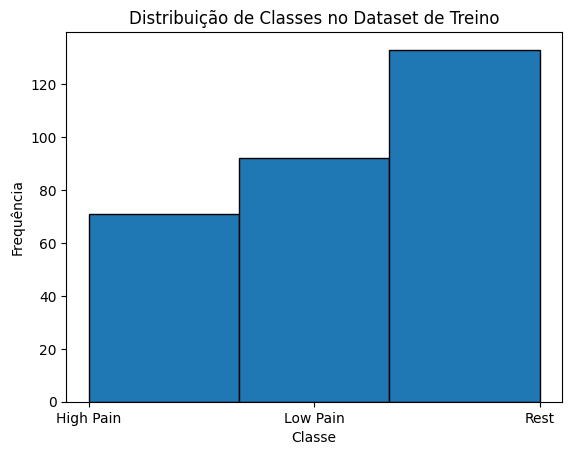

KeyboardInterrupt: 

In [21]:
# Verifica a distribuição das classes

labels = []
for _, label_batch in train_dataset: # train_dataset verifica para o treino, val_dataset para validação
    labels.extend(label_batch.numpy()) 

import matplotlib.pyplot as plt
plt.hist(labels, bins=3, edgecolor='black')
plt.xticks([0, 1, 2], ["High Pain", "Low Pain", "Rest"])
plt.xlabel("Classe")
plt.ylabel("Frequência")
plt.title("Distribuição de Classes no Dataset de Treino")
plt.show()

labels = []
for _, label_batch in val_dataset: # train_dataset verifica para o treino, val_dataset para validação
    labels.extend(label_batch.numpy()) 

import matplotlib.pyplot as plt
plt.hist(labels, bins=3, edgecolor='black')
plt.xticks([0, 1, 2], ["High Pain", "Low Pain", "Rest"])
plt.xlabel("Classe")
plt.ylabel("Frequência")
plt.title("Distribuição de Classes no Dataset de Validação")
plt.show()


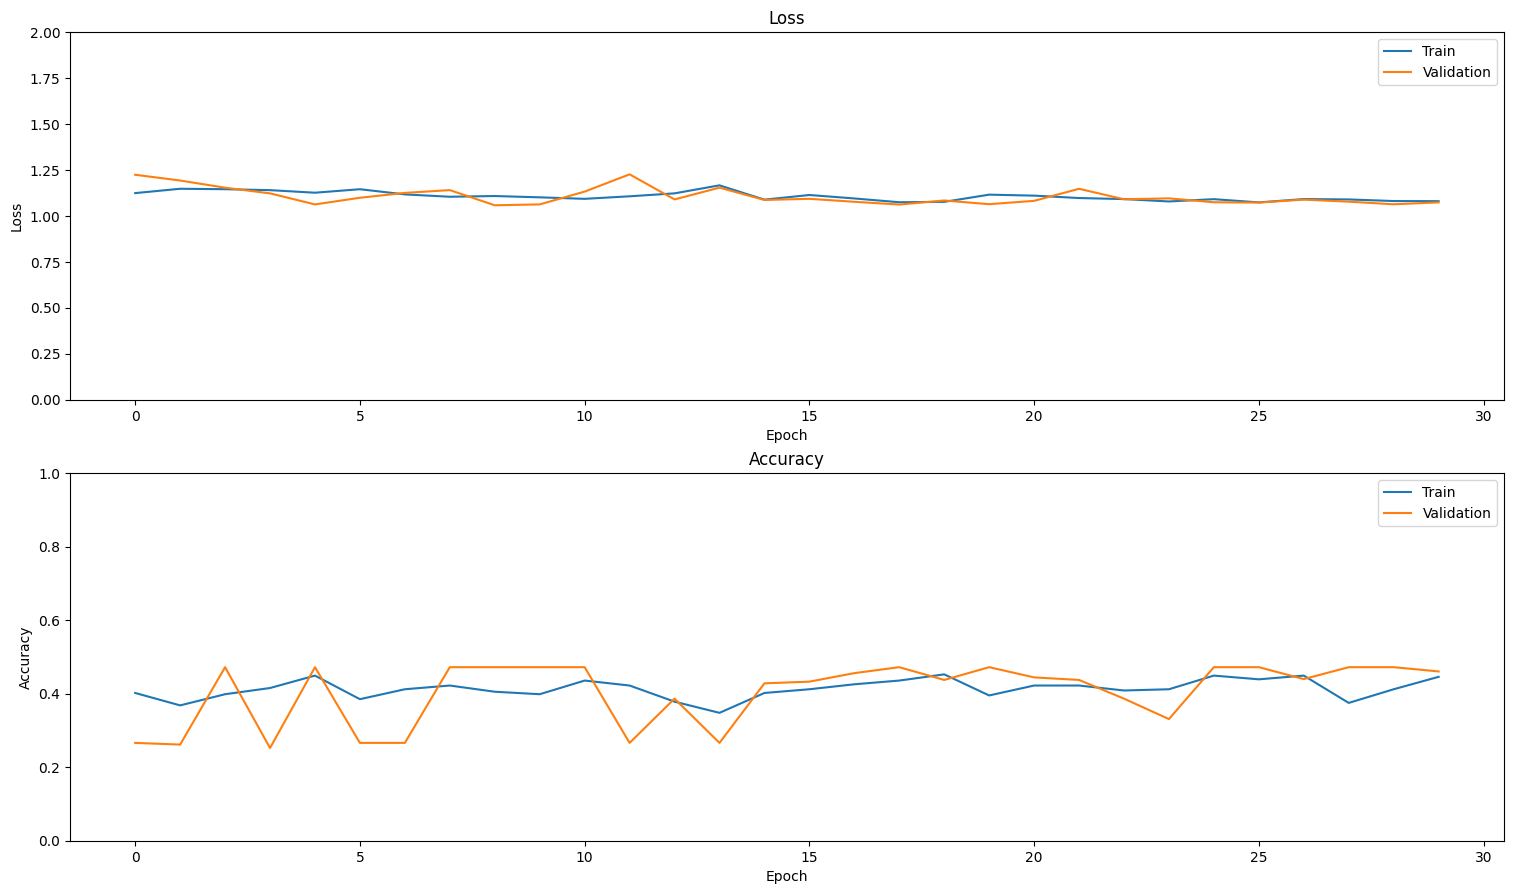

In [22]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [ ]:
model = model.load_weights()

TypeError: Conv2Plus1D.__init__() got an unexpected keyword argument 'name'

1/1 [==============================] - 0s 266ms/step


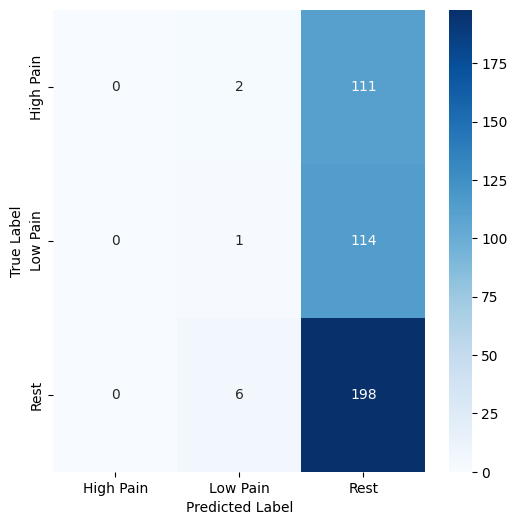

In [23]:
from sklearn.metrics import confusion_matrix

# Definir classes
class_names = ["High Pain", "Low Pain", "Rest"]

# Obter previsões do modelo
y_true = []
y_pred = []

for video_batch, label_batch in val_dataset:
    preds = model.predict(video_batch)  # Previsões do modelo
    y_pred.extend(np.argmax(preds, axis=-1))  # Converter para rótulos
    y_true.extend(label_batch.numpy())  # Rótulos verdadeiros

# Gerar matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Plotar matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Exemplo para o dataset de treino
for data, labels in train_dataset.take(5):  # 'take(5)' pega as primeiras 5 amostras
    print("Data shape:", data.shape)  # Para visualizar a forma dos dados (ex.: imagens)
    print("Labels:", labels.numpy())  # Para visualizar os rótulos


Data shape: (2, 60, 224, 224, 3)
Labels: [0 2]
Data shape: (2, 60, 224, 224, 3)
Labels: [0 0]
Data shape: (2, 60, 224, 224, 3)
Labels: [2 2]
Data shape: (2, 60, 224, 224, 3)
Labels: [0 1]
Data shape: (2, 60, 224, 224, 3)
Labels: [1 1]


In [ ]:
import numpy as np

# Função para verificar a distribuição dos rótulos
def check_label_distribution(dataset):
    label_counts = {}
    for _, labels in dataset:
        for label in labels.numpy():
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
    return label_counts

# Verificar no dataset de treino
train_label_distribution = check_label_distribution(train_dataset)
print("Distribuição de rótulos no treino:", train_label_distribution)

# Verificar no dataset de validação
val_label_distribution = check_label_distribution(val_dataset)
print("Distribuição de rótulos na validação:", val_label_distribution)


Distribuição de rótulos no treino: {2: 133, 0: 71, 1: 92}
Distribuição de rótulos na validação: {2: 204, 0: 113, 1: 115}


In [ ]:
model.save("modelo2_tf", save_format="tf") 

INFO:tensorflow:Assets written to: modelo2_tf\assets


INFO:tensorflow:Assets written to: modelo2_tf\assets


In [ ]:
# para carregar o modelo
# from tensorflow.keras.models import load_model

# modelo_carregado = load_model("modelo1_tf")


### Teste

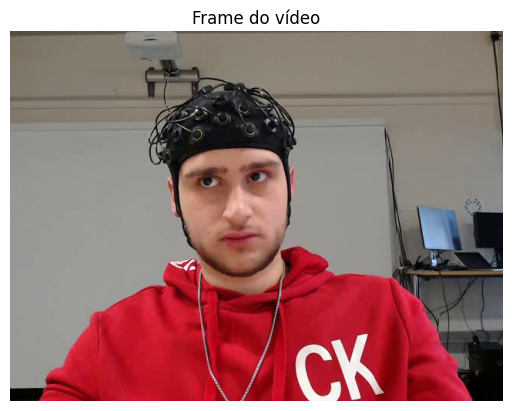

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Teste de leitura direta de vídeo
video_path = ".\Train\\video\\3\\3_Rest_3.mp4"  # Substituir com o caminho real
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Erro ao abrir o vídeo.")
else:
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Converte BGR para RGB
        plt.title("Frame do vídeo")
        plt.axis("off")
        plt.show()
    else:
        print("Não foi possível ler o frame.")
cap.release()
